In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression #mutual_info_classif pour un categorical target
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [25]:
df_sessions = pd.read_csv("data/sessions.csv")
df_ocpp = pd.read_csv("data/ocpp.csv")

In [26]:
df_sessions.describe()

,connector_id,sessions,failed_sessions
count,442644.000000,442644.000000,442644.000000
mean,2.829579,1.868364,0.140092
std,1.827437,1.452230,0.721880
min,1.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,2.000000,1.000000,0.000000
75%,4.000000,2.000000,0.000000
max,8.000000,174.000000,174.000000


In [27]:
df_sessions.head()

,charge_date,charger_id,connector_id,sessions,failed_sessions
0,2023-01-16,34406128,5,4,0
1,2023-01-23,37A80B4D,3,3,3
2,2023-01-18,AA92D18E,2,2,0
3,2023-01-28,FF15DC0B,3,2,0
4,2023-01-19,06B95C56,2,1,0


In [28]:
df_ocpp.describe()

,connector_id,total_error_notifications
count,1.980945e+06,1.980945e+06
mean,2.446750e+00,5.915192e+01
std,2.244263e+00,1.544700e+03
min,0.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00
75%,4.000000e+00,3.000000e+00
max,2.200000e+01,9.820000e+04


In [29]:
df_ocpp.head()

,supplier,charger_id,connector_id,error_code,vendor_error_code,total_error_notifications,error_at
0,513B5F6A,4365B1B8,8,InternalError,sessmgr.emvPaymentController,1,2023-09-07
1,513B5F6A,790A884E,3,OtherError,RemoteStart,1,2023-08-10
2,513B5F6A,4365B1B8,8,InternalError,ServiceFail,1,2023-09-07
3,513B5F6A,123468DF,5,EVCommunicationError,COMMUNICATION_ERROR,1,2023-07-24
4,513B5F6A,02D469F0,7,InternalError,ServiceFail,2,2023-06-16


In [30]:
df_errors_sum = df_ocpp.groupby(['supplier', 'charger_id', 'connector_id', 'error_code', 'error_at'])['total_error_notifications'].sum().reset_index()
df_merged = df_ocpp.merge(df_errors_sum, on=['supplier', 'charger_id', 'connector_id', 'error_code', 'error_at'], how='left', suffixes=('', '_sum'))
X_encoded = pd.get_dummies(df_merged['error_code'], prefix="error")
df_ocpp1 = X_encoded.mul(df_merged['total_error_notifications_sum'], axis=0)
#df_ocpp2 = pd.get_dummies(df_ocpp.vendor_error_code, prefix="vendor_error")
#df_ocpp2 = df_ocpp2.mul(df_ocpp.total_error_notifications, axis=0)
df_ocpp3 = pd.get_dummies(df_ocpp.supplier, prefix="supplier")
df_final = pd.concat([df_ocpp[['charger_id', 'connector_id', 'error_at']], df_ocpp1, df_ocpp3], axis=1).drop_duplicates()

In [31]:
df_final.head()

,charger_id,connector_id,error_at,error_ConnectorLockFailure,error_EVCommunicationError,error_GroundFailure,error_HighTemperature,error_InternalError,error_OtherError,error_OverCurrentFailure,...,supplier_03C1B10B,supplier_079BE758,supplier_32EE10C9,supplier_497B9DD5,supplier_513B5F6A,supplier_800CD720,supplier_8695B55A,supplier_A789408E,supplier_D439671D,supplier_F51175CB
0,4365B1B8,8,2023-09-07,0.0,0.0,0.0,0.0,4197.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
1,790A884E,3,2023-08-10,0.0,0.0,0.0,0.0,0.0,669.0,0.0,...,False,False,False,False,True,False,False,False,False,False
3,123468DF,5,2023-07-24,0.0,586.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
4,02D469F0,7,2023-06-16,0.0,0.0,0.0,0.0,586.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
5,721A1D3E,4,2024-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False


In [32]:
df_sessions_final = pd.read_csv("data/processed_data.csv")

In [33]:
df_merged = pd.merge(df_final, df_sessions_final, on=['charger_id', 'connector_id', 'error_at'], how='inner')
df_clean = pd.read_csv("data/dataset_clean_shift.csv")
df_clean = df_clean.drop(columns=['sessions', 'failed_sessions', 'year','failure_probability'])
df_final = pd.merge(df_merged, df_clean, on=['charger_id', 'connector_id', 'error_at'], how='inner')
df_final = df_final.drop(columns=['charger_id', 'connector_id', 'error_at'])

In [34]:
df_final.describe()

,error_ConnectorLockFailure,error_EVCommunicationError,error_GroundFailure,error_HighTemperature,error_InternalError,error_OtherError,error_OverCurrentFailure,error_OverVoltage,error_PowerMeterFailure,error_PowerSwitchFailure,error_ReaderFailure,error_UnderVoltage,target,sessions_7d,no_session_days,failure_rate_7d,errors_7d
count,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000,2611.0,2611.000000,2611.000000
mean,1.698966,14.026044,28.133665,6.635006,544.162007,196.673688,5.017235,20.465722,0.821141,0.145155,1.237840,4.080812,0.524045,12.693604,0.0,0.383644,3.860973
std,41.052594,205.076837,191.450231,142.506351,7840.990853,1544.471124,124.904933,111.959660,19.717754,3.684179,22.479989,109.423676,0.252495,9.264253,0.0,0.740529,3.332904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106838,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,8.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.473016,11.000000,0.0,0.142857,4.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.654762,16.000000,0.0,0.428571,7.000000
max,1824.000000,8430.000000,4940.000000,6703.000000,192472.000000,67390.000000,5274.000000,2344.000000,903.000000,127.000000,869.000000,4981.000000,1.000000,82.000000,0.0,9.285714,11.000000


In [35]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [36]:
X = df_final
y = X.pop('target')

In [37]:
mi_scores = make_mi_scores(X, y)

In [38]:
print(mi_scores.head(20))

errors_7d                     0.297522
sessions_7d                   0.200587
failure_rate_7d               0.131686
supplier_03C1B10B             0.045698
error_InternalError           0.042960
error_OtherError              0.037137
supplier_A789408E             0.032163
supplier_513B5F6A             0.032158
supplier_8695B55A             0.031064
supplier_800CD720             0.025580
supplier_079BE758             0.017928
error_OverVoltage             0.017375
error_UnderVoltage            0.013455
error_GroundFailure           0.012247
supplier_497B9DD5             0.009899
error_ConnectorLockFailure    0.007758
error_EVCommunicationError    0.005895
supplier_D439671D             0.003952
no_session_days               0.000191
error_ReaderFailure           0.000000
Name: MI Scores, dtype: float64


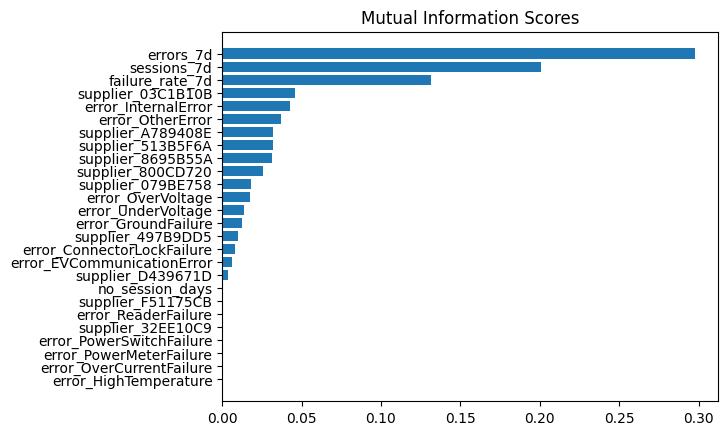

In [39]:
plot_mi_scores(mi_scores)

In [40]:
final = df_final[mi_scores.head(10).index.tolist()]

In [41]:
final.describe()

,errors_7d,sessions_7d,failure_rate_7d,error_InternalError,error_OtherError
count,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000
mean,3.860973,12.693604,0.383644,544.162007,196.673688
std,3.332904,9.264253,0.740529,7840.990853,1544.471124
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,0.000000,0.000000,0.000000
50%,4.000000,11.000000,0.142857,0.000000,1.000000
75%,7.000000,16.000000,0.428571,0.000000,71.000000
max,11.000000,82.000000,9.285714,192472.000000,67390.000000


In [42]:
final.to_csv('data/final.csv',index=False)